# Test tSSS movement compensation with gradient compensations on CTF data

## Steps
* Interpolate always bads

* [optional]: Remove channel-noise (incl. squid jumps) by oversampled_temporal_projection  
[example](https://mne-tools.github.io/dev/auto_examples/preprocessing/plot_otp.html#sphx-glr-auto-examples-preprocessing-plot-otp-py), [doc](http://www.nmr.mgh.harvard.edu/mne/dev/generated/mne.preprocessing.oversampled_temporal_projection.html), [commit](https://github.com/mne-tools/mne-python/commit/e62a46a1ae3200bfdfb8cb8d48c6bde3810c1fe6), [paper](https://www.researchgate.net/publication/318811352_Reducing_Sensor_Noise_in_MEG_and_EEG_Recordings_Using_Oversampled_Temporal_Projection)  
> Note: "OTP can improve sensor noise levels (especially under visual inspection) and repair some bad channels. This noise reduction is known to interact with tSSS such that increasing the st_correlation value will likely be necessary."

* Extract head position by [`mne.chpi._calculate_head_pos_ctf`](https://github.com/mne-tools/mne-python/pull/4088)  
(for Elektra files: [generating head pos](https://mail.nmr.mgh.harvard.edu/pipermail/mne_analysis/2016-July/003440.html), [reading head pos](https://mne-tools.github.io/dev/generated/mne.chpi.read_head_pos.html#mne.chpi.read_head_pos), using the [command line option](https://mne-tools.github.io/dev/generated/commands.html?highlight=maxfilter#mne-maxfilter))

* Movement compensation and re-alignment by tSSS (maxwell_filter)  
[example](https://mne-tools.github.io/dev/auto_examples/preprocessing/plot_movement_compensation.html?highlight=movement%20compensation), [manual](https://www.martinos.org/mne/dev/manual/preprocessing/maxwell.html), [doc raw](https://mne-tools.github.io/dev/generated/mne.preprocessing.maxwell_filter.html?highlight=movement%20compensation), [doc epochs](https://mne-tools.github.io/dev/generated/mne.epochs.average_movements.html?highlight=movement%20compensation),
[paper](https://link.springer.com/article/10.1007/s10548-016-0523-1), [old paper](https://www.researchgate.net/publication/5782712_Artifact_and_head_movement_compensation_in_MEG)
    - Compare different combinations of gradien compensation and tSSS

## Discussions
### [github-discussion from 2015](https://github.com/mne-tools/mne-python/issues/2277):
>As for the reference sensor compensation, such as the 3rd order gradiometrization in CTF systems, the compatibility of the compensated data with MaxFilter depends on how the compensation is done. As far as I understand, the CTF compensation is done by suppressing the homogeneous fields and the 1st and 2nd order derivatives of the external fields based on the reference sensor recordings. This kind of data can be processed with MaxFilter without any extra manipulations and the resulting data should have any required forward-model reconstructions automatically applied, just like in the case of Elekta's active compensation.  
staulu

>Your comment made me realize that it is actually not feasible to perform the reference sensor based compensation if SSS has already been applied to the whole CTF array (actual sensors + reference sensors) because all the reconstructed signals will be of internal origin and the assumptions that justify using external Taylor's expansion for the extrapolation of reference signals don't hold true anymore. The solution would be 1) just to apply SSS on the whole array (it will be numerically more stable thanks to the reference sensors) and consider this the final interference suppression step without additional reference sensor compensation, or 2) first perform the 3rd order gradiometrization and then possibly do SSS depending on the details of the compensation. I think this topic requires some extensive thinking and planning, maybe in a future project :)  
staulu

### [github-discussion from 2019](https://github.com/mne-tools/mne-python/issues/5960)  
>Thanks again for your answers. So, to summarize, as of the current state SSS and gradient comp cannot really be combined, right?
>1. (t)SSS --> gradient compensation: Problematic due to Taylor assumptions probably not met anymore.
>2. gradient compensation --> (t)SSS: Needs adaptions in the core of the maxwell code (applying the gradient comp also to the SSS model).
Option 2 is theoretically sound and just needs to be implemented, for option 1 further theoretical insight is needed.  
    jeythekey

>I basically agree. I have a couple of comments:
>1. In the case of (t)SSS --> gradient compensation, one assumes that the data contain signals of external origin that can be reconstructed from the reference sensor measurement. However, if the actual MEG channels have been processed by (t)SSS, then extrapolating and subtracting external interference based on reference sensors (gradient compensation) will most probably increase interference in the (t)SSS-processed data.
>2. In principle, if the gradient compensation is applied to purely subtract homogeneous fields or low-order gradients of the external field from the measurement, then one shouldn't necessarily need to modify the SSS model because such a subtraction, if done properly, shouldn't fundamentally alter the spatial pattern of the brain signal. But whether the SSS model needs to be modified or not depends on the details of the gradient compensation. Anyway, this should be a doable option.  
    staulu

### in fieldtrip:
- http://www.fieldtriptoolbox.org/example/how_to_incorporate_head_movements_in_meg_analysis/
- http://www.fieldtriptoolbox.org/reference/ft_megrealign/
- http://www.fieldtriptoolbox.org/reference/ft_regressconfound/

## Info about gradient compensation from CTF manual
>[...] Thus, a well designed, unshielded 3rd-order gradiometer offers a level of noise discrimination equal to, or better than, that of a shielded lower-order system. [...] 

>To resolve this issue, the CTF MEG System implements high- order gradiometer formation through software, as shown in Figure 7 (c). This system uses a low-order, hardware gradient detector (e.g., 1st-order) that is then processed relative to a common reference system to form a higher-order gradient response. This technique is not adaptive. The coefficients involved are time independent, and only one reference system is needed for an arbitrary number of detecting channels. [...] 

>In addition to these gradiometer sensor coils (flux transformers), the system includes a number of reference coils for environmental noise cancellation. This environmental noise cancellation array supplies all of the necessary information on the magnetic field vector and the gradient tensors in the vicinity of the sensor coils to eliminate the effects of uniform field and gradient common-mode noise. **This is implemented through a _proprietary digital signal processing algorithm_, in effect constructing an array of well-balanced higher-order virtual gradiometers in software.** The noise rejection is discussed in “Environmental Noise Rejection” on page 50. [...] 


>The front-end sensors on the MEG system are already first- order axial gradiometers. The higher-gradient formation noise cancellation utilizes a set of reference channels to synthetically generate second- or third-order gradient sensors. The method works by adding a carefully calculated linear combination of reference channels to each sensor channel. The process is linear so that it may be applied or removed with no ill affects. It is possible to gain all the benefits of higher-order gradient formation during post-processing. [...] 

>CTF-manual technical description



## Test

### Imports

In [1]:
# set figure size:
# %matplotlib widget
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [8, 5]

# general:
import numpy as np

# mne
import mne
from mne.preprocessing import maxwell_filter
from mne.chpi import _calculate_head_pos_ctf, head_pos_to_trans_rot_t
from mne.fixes import einsum

# my own stuff:
from utils import loadRawEvents, loadRun

### Load data, add annotations etc. (my own stuff ...)

In [2]:
raw, ev, info, cndrows, endrows = loadRawEvents('SZ14G', 1, preload=False)#[:2]
raw = loadRun(raw, ev, cndrows, endrows, meg=True, ref_meg=True, eog=False, ecg=False, emg=False, ias=True)
# ias = headloc (hlc-chans)
# HP-filter at .1 Hz applied (Maxwell with 10 sec windows have that effect as well.)
raw.crop(tmin=20, tmax=30)  # 10 secs of data

Found 4 blocks in run 1.
ds directory : /run/media/johannes/J1-2TBexfat/Promotion/dataMEG/keepPitch/data/raw/SZ14G_PromophonTest_20170914_01.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.68   77.75    0.00 mm <->    0.68   77.75    0.00 mm (orig :  -60.10   49.66 -268.16 mm) diff =    0.000 mm
      -0.68  -77.75    0.00 mm <->   -0.68  -77.75    0.00 mm (orig :   49.56  -60.50 -263.99 mm) diff =    0.000 mm
     112.66    0.00    0.00 mm <->  112.66    0.00    0.00 mm (orig :   73.23   74.56 -254.58 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    4 EEG electrode locations assigned to channel info.
    4 EEG locations added to Polhemus data.
    Measurement info composed.
Finding samples for /run/media/johannes/J1-2TBexfat/Promotion/dataMEG/keepPitch/data/raw/SZ14G_PromophonT

/home/johannes/FORSCHUNG/Promotion/Analysen/keepPitch/MEG/PYTHON/utils.py:267: RuntimeWarning: The unit for channel(s) HLC0011, HLC0012, HLC0013, HLC0021, HLC0022, HLC0023, HLC0031, HLC0032, HLC0033 has changed from V to NA.
  raw.set_channel_types(mapping=mapping)
/home/johannes/FORSCHUNG/Promotion/Analysen/keepPitch/MEG/PYTHON/utils.py:288: UserWarning: loadtxt: Empty input file: "/run/media/johannes/J1-2TBexfat/Promotion/dataMEG/keepPitch/data/preproc/A04_artefInteract_postICA/SZ14G/bads/rn1_bads.txt"
  if op.isfile(pa.path_bads_postICA) and np.loadtxt(pa.path_bads_postICA, dtype=str, ndmin=1).tolist():


HP filtering at .1 Hz ...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz
l_trans_bandwidth chosen to be 0.1 Hz
Filter length of 39601 samples (33.001 sec) selected


<RawCTF  |  SZ14G_PromophonTest_20170914_01.meg4, n_channels x n_times : 306 x 12001 (10.0 sec), ~28.8 MB, data loaded>

### Calc and plot head-pos

    Coordinate transformations established.


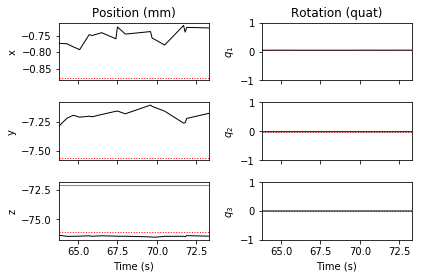

In [3]:
head_pos = _calculate_head_pos_ctf(raw)

mne.viz.plot_head_positions(
    head_pos, mode='traces', destination=None, info=raw.info);  # raw.info['dev_head_t'], None
# plots in device coordinates [head_dev_t] (otherwise, would start at zero)
# --> destination, given in [dev_head_t], is plotted inverted.

In [4]:
## Use mean head-trans as destination later
destination = np.mean(head_pos[..., 4:7], axis=0)  # this is the trans, without rotation

### A) Plot raw with different gradient compensations (no tSSS)

In [5]:
## prepare raw plot
def myrawplot(raw, tit):
    picks = mne.pick_types(raw.info, meg=True, ref_meg=False, eeg=False, eog=False,
                       ecg=False, stim=False, exclude=[]) #, selection=selection, ref_meg=False,

    fig = raw.plot(order=picks, scalings=None, lowpass=70, highpass=0.1,  #, scalings='None'auto'
         butterfly=False, duration=10 , n_channels=10, # group_by='position', n_channels=int(np.ceil(len(picks)/2))
         remove_dc=True, title=tit);

    return fig

Compensator constructed to change 3 -> 0
Applying compensator to loaded data


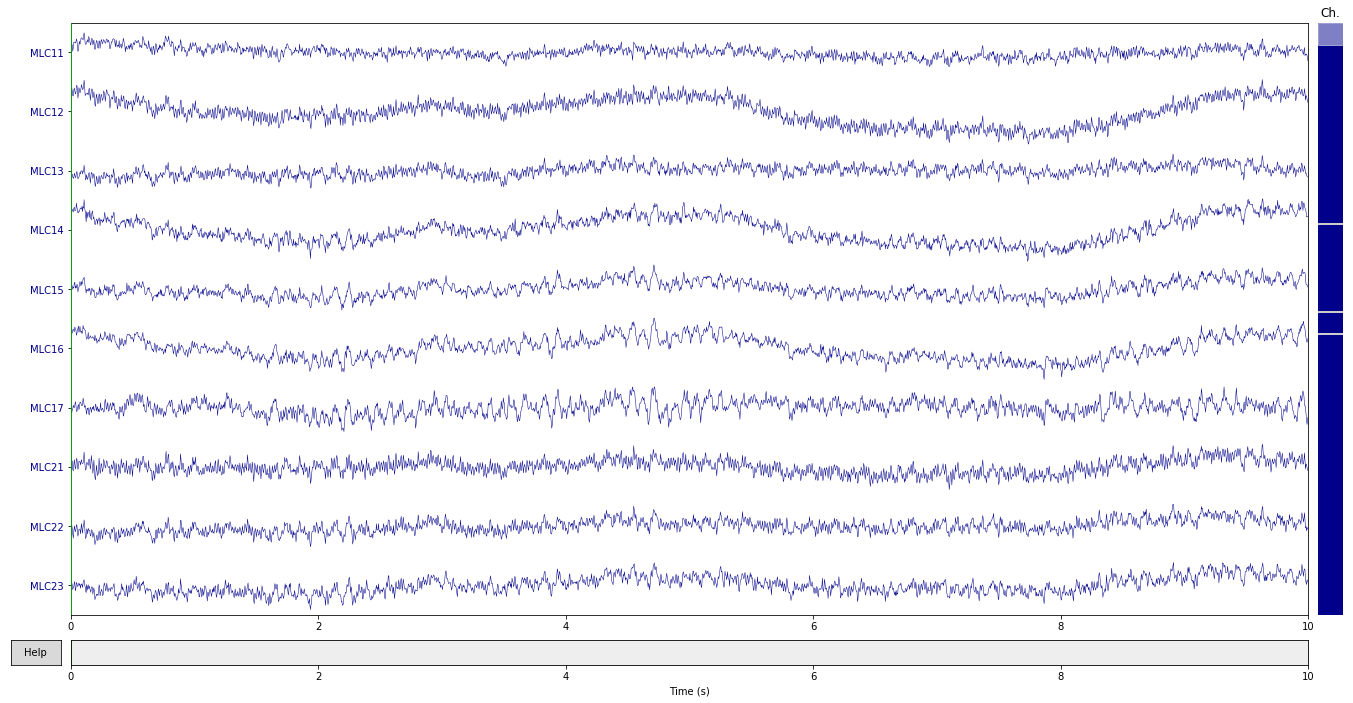

In [6]:
tit = "no grad comp"
raw_tmp = raw.copy().apply_gradient_compensation(0)
fig = myrawplot(raw_tmp, tit)

Compensator constructed to change 3 -> 1
Applying compensator to loaded data


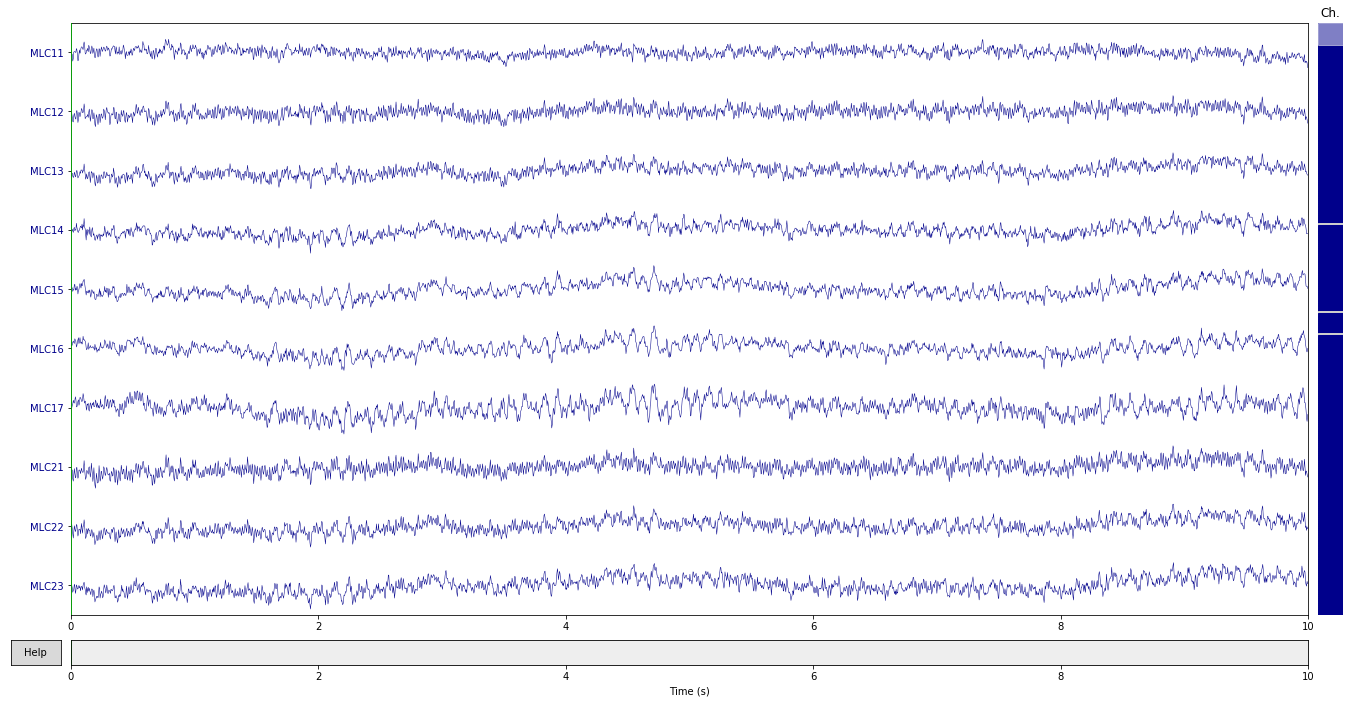

In [7]:
tit = "1st order grad comp"
raw_tmp = raw.copy().apply_gradient_compensation(1)
fig = myrawplot(raw_tmp, tit)

Compensator constructed to change 3 -> 2
Applying compensator to loaded data


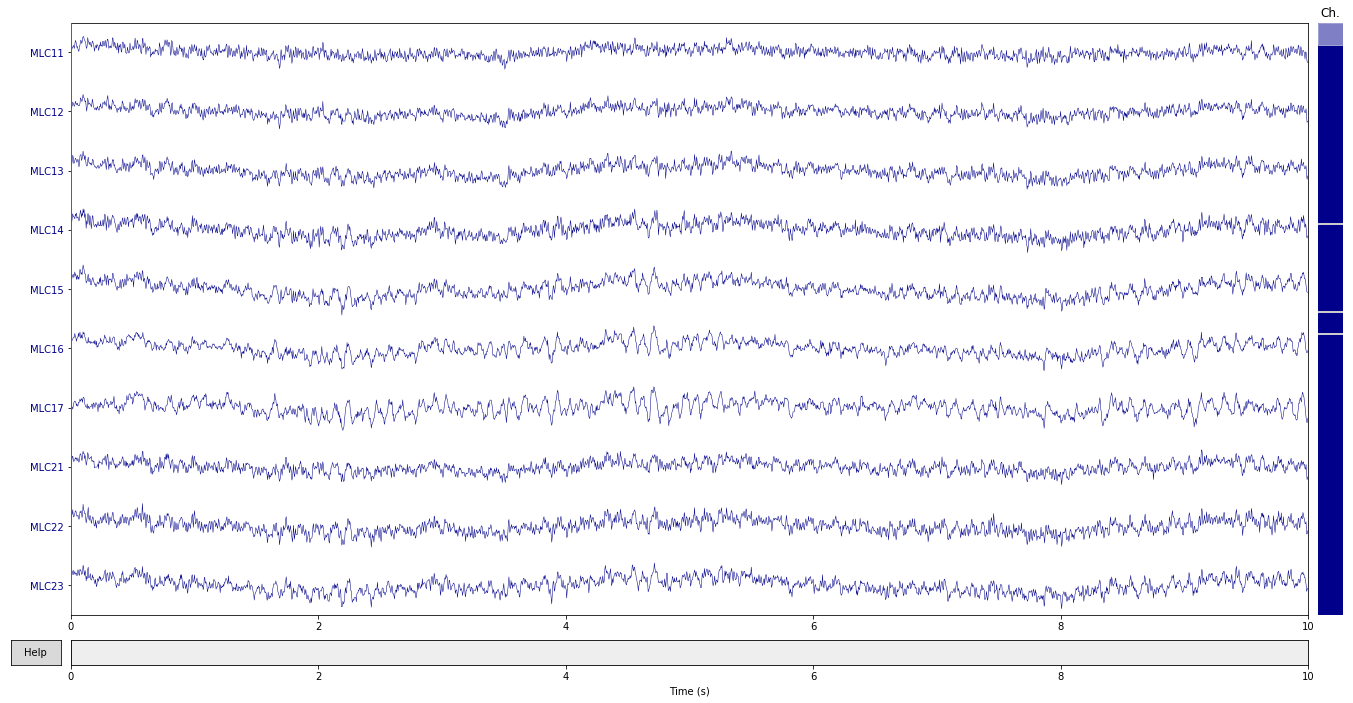

In [8]:
tit = "2nd order grad comp"
raw_tmp = raw.copy().apply_gradient_compensation(2)
# not recommneded to change grad-comp several times --> copy
fig = myrawplot(raw_tmp, tit)

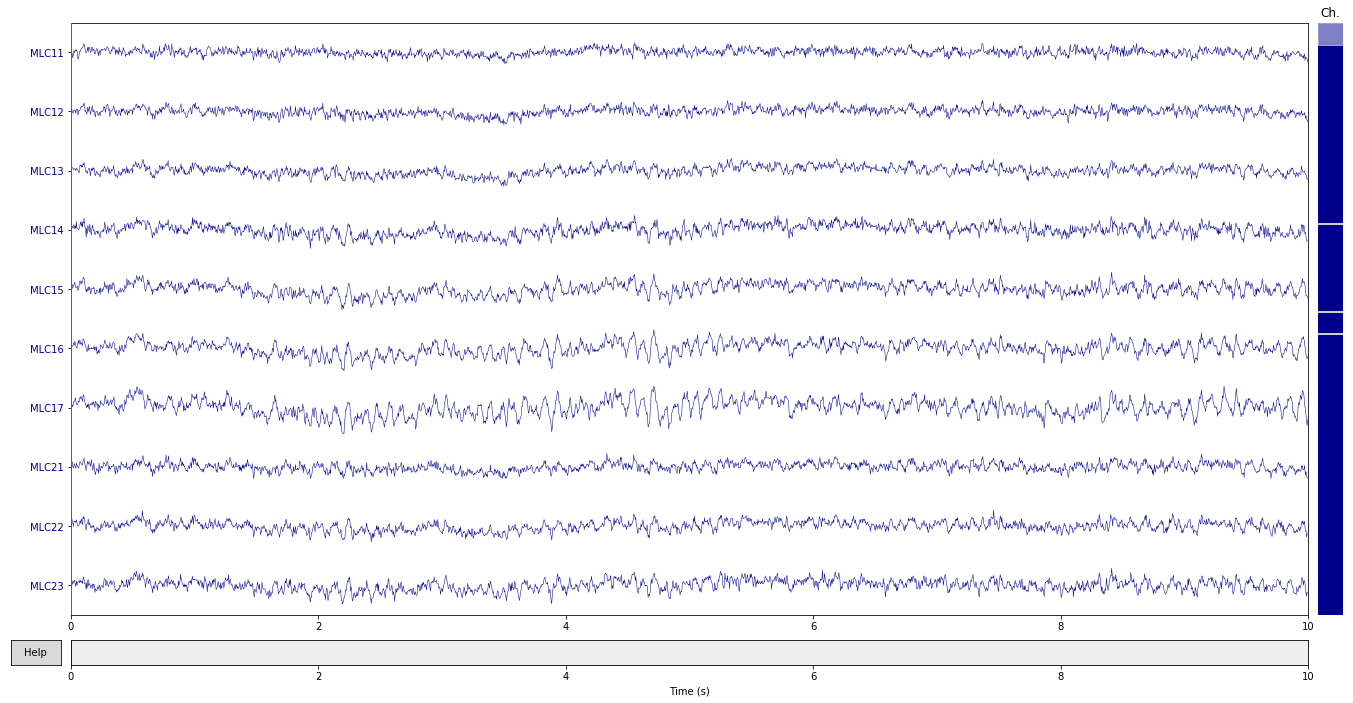

In [9]:
tit = "3rd order grad comp"
fig = myrawplot(raw, tit)  # is already applied

#### Summary
As expected, the default 3rd order gradient compensation looks cleanest. Most of the slow drifts got removed.

### B) Plot raw with grad-comp (different orders) --> tSSS

In [10]:
def mymaxwell(raw, destination, head_pos):
    raw_sss = maxwell_filter(raw, st_duration=10,
                           destination= destination,  # in head coordinates
                           st_correlation=.98,
                           ignore_ref=True,
                           coord_frame='head',
                           head_pos=head_pos,  # head_pos or None
                           st_fixed=True,
                           st_only=False,
                           skip_by_annotation=('bad', 'edge', 'bad_acq_skip'))
    return raw_sss

Compensator constructed to change 3 -> 0
Applying compensator to loaded data
Maxwell filtering raw data
    Appending head position result channels and copying original raw data
Removing 5 compensators from info because not all compensation channels were picked.
    Bad MEG channels being reconstructed: ['MLP53', 'MRC12', 'MRC25']
    Processing 0 gradiometers and 269 magnetometers (of which 269 are actually KIT gradiometers)
    Automatic origin fit: head of radius 86.7 mm
    Using origin 1.0, -23.9, 38.5 mm in the head frame
    Processing data using tSSS with st_duration=10.0
        Using 82/95 harmonic components for    0.000  (70/80 in, 12/15 out)
    Processing 1 data chunk


<ipython-input-10-eed8a0bf3da7>:10: RuntimeWarning: Only 4 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  skip_by_annotation=('bad', 'edge', 'bad_acq_skip'))
<ipython-input-10-eed8a0bf3da7>:10: RuntimeWarning: (X, Y) fit (1.0, -23.9) more than 20 mm from head frame origin
  skip_by_annotation=('bad', 'edge', 'bad_acq_skip'))


        Using 83/95 harmonic components for    0.000  (71/80 in, 12/15 out)
        Projecting  1 intersecting tSSS component  for    0.000 -   10.000 sec (#1/1) (across 18 positions)
        Using 82/95 harmonic components for    0.000  (70/80 in, 12/15 out)
        Using 82/95 harmonic components for    0.516  (70/80 in, 12/15 out)
        Using 82/95 harmonic components for    0.916  (70/80 in, 12/15 out)
        Using 82/95 harmonic components for    1.316  (70/80 in, 12/15 out)
        Using 82/95 harmonic components for    1.916  (70/80 in, 12/15 out)
        Using 82/95 harmonic components for    2.116  (70/80 in, 12/15 out)
        Using 82/95 harmonic components for    2.716  (70/80 in, 12/15 out)
        Using 82/95 harmonic components for    3.616  (70/80 in, 12/15 out)
        Using 82/95 harmonic components for    3.716  (70/80 in, 12/15 out)
        Using 82/95 harmonic components for    4.216  (70/80 in, 12/15 out)
        Using 82/95 harmonic components for    5.816  (7

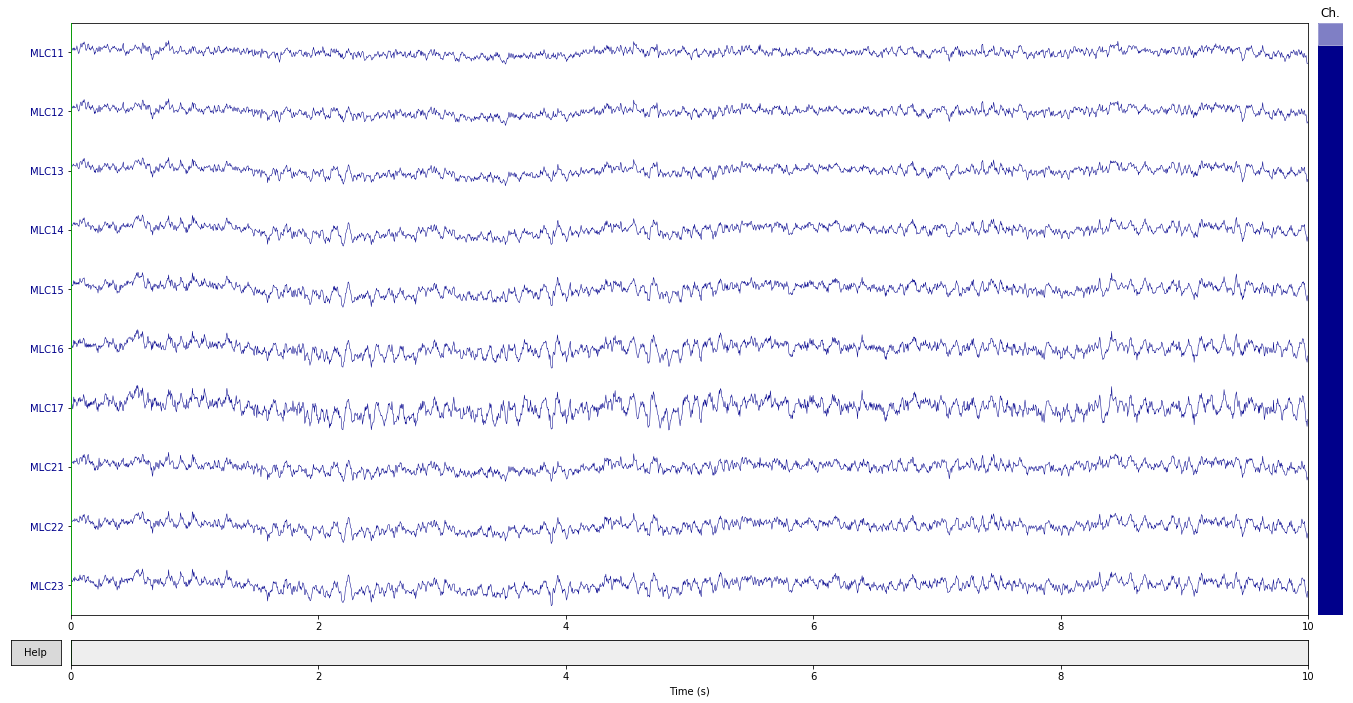

In [11]:
# Maxwell only
tit = "no grad comp --> tSSS +mvmntComp +destMean -ref"

raw_sss = raw.copy().apply_gradient_compensation(0)
raw_sss = mymaxwell(raw_sss, destination, head_pos)
fig = myrawplot(raw_sss, tit)

Compensator constructed to change 3 -> 1
Applying compensator to loaded data
Maxwell filtering raw data
    Appending head position result channels and copying original raw data
Removing 5 compensators from info because not all compensation channels were picked.
    Bad MEG channels being reconstructed: ['MLP53', 'MRC12', 'MRC25']
    Processing 0 gradiometers and 269 magnetometers
    Automatic origin fit: head of radius 86.7 mm
    Using origin 1.0, -23.9, 38.5 mm in the head frame
    Processing data using tSSS with st_duration=10.0
        Using 85/95 harmonic components for    0.000  (70/80 in, 15/15 out)
    Processing 1 data chunk


<ipython-input-10-eed8a0bf3da7>:10: RuntimeWarning: Only 4 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  skip_by_annotation=('bad', 'edge', 'bad_acq_skip'))
<ipython-input-10-eed8a0bf3da7>:10: RuntimeWarning: (X, Y) fit (1.0, -23.9) more than 20 mm from head frame origin
  skip_by_annotation=('bad', 'edge', 'bad_acq_skip'))


        Using 86/95 harmonic components for    0.000  (71/80 in, 15/15 out)
        Projecting  0 intersecting tSSS components for    0.000 -   10.000 sec (#1/1) (across 18 positions)
        Using 85/95 harmonic components for    0.000  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    0.516  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    0.916  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    1.316  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    1.916  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    2.116  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    2.716  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    3.616  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    3.716  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    4.216  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    5.816  (7

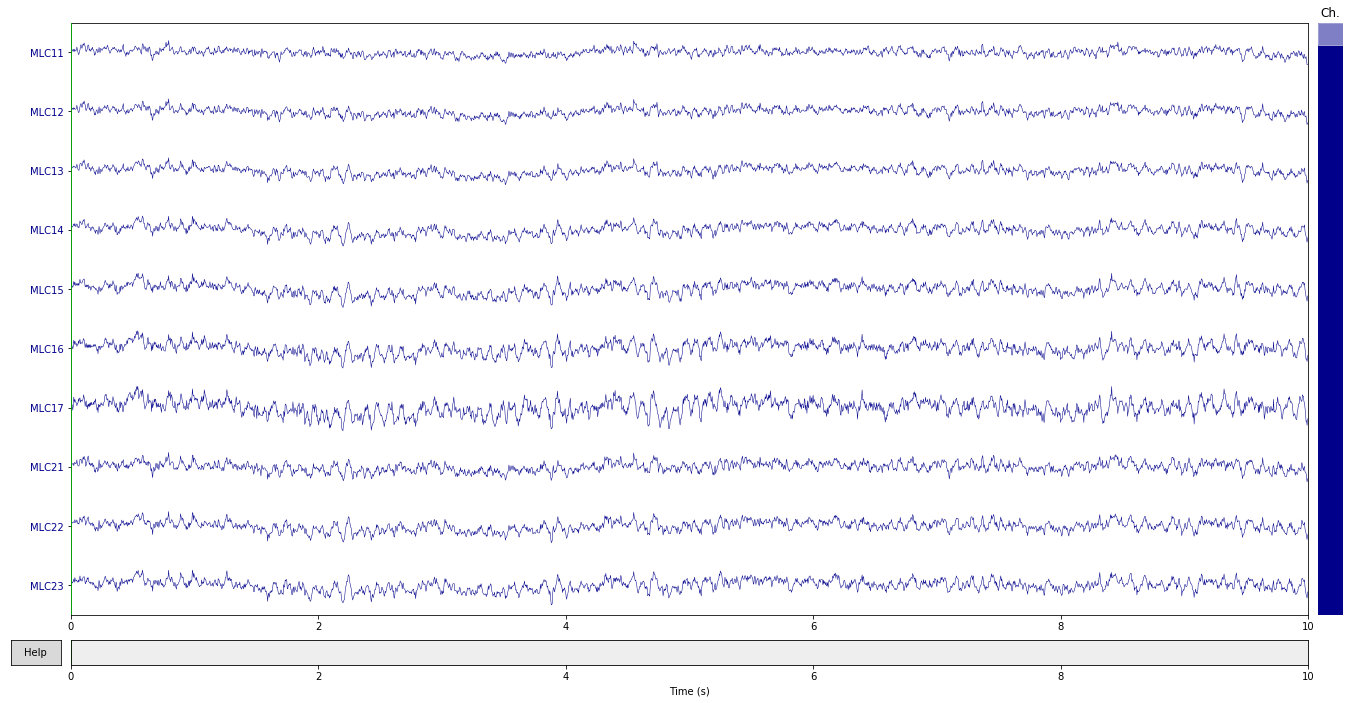

In [12]:
tit = "1st order grad comp --> tSSS +mvmntComp +destMean -ref"

raw_sss = raw.copy().apply_gradient_compensation(1)
raw_sss = mymaxwell(raw_sss, destination, head_pos)
fig = myrawplot(raw_sss, tit)

Compensator constructed to change 3 -> 2
Applying compensator to loaded data
Maxwell filtering raw data
    Appending head position result channels and copying original raw data
Removing 5 compensators from info because not all compensation channels were picked.
    Bad MEG channels being reconstructed: ['MLP53', 'MRC12', 'MRC25']
    Processing 0 gradiometers and 269 magnetometers
    Automatic origin fit: head of radius 86.7 mm
    Using origin 1.0, -23.9, 38.5 mm in the head frame
    Processing data using tSSS with st_duration=10.0
        Using 85/95 harmonic components for    0.000  (70/80 in, 15/15 out)
    Processing 1 data chunk


<ipython-input-10-eed8a0bf3da7>:10: RuntimeWarning: Only 4 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  skip_by_annotation=('bad', 'edge', 'bad_acq_skip'))
<ipython-input-10-eed8a0bf3da7>:10: RuntimeWarning: (X, Y) fit (1.0, -23.9) more than 20 mm from head frame origin
  skip_by_annotation=('bad', 'edge', 'bad_acq_skip'))


        Using 86/95 harmonic components for    0.000  (71/80 in, 15/15 out)
        Projecting  0 intersecting tSSS components for    0.000 -   10.000 sec (#1/1) (across 18 positions)
        Using 85/95 harmonic components for    0.000  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    0.516  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    0.916  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    1.316  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    1.916  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    2.116  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    2.716  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    3.616  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    3.716  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    4.216  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    5.816  (7

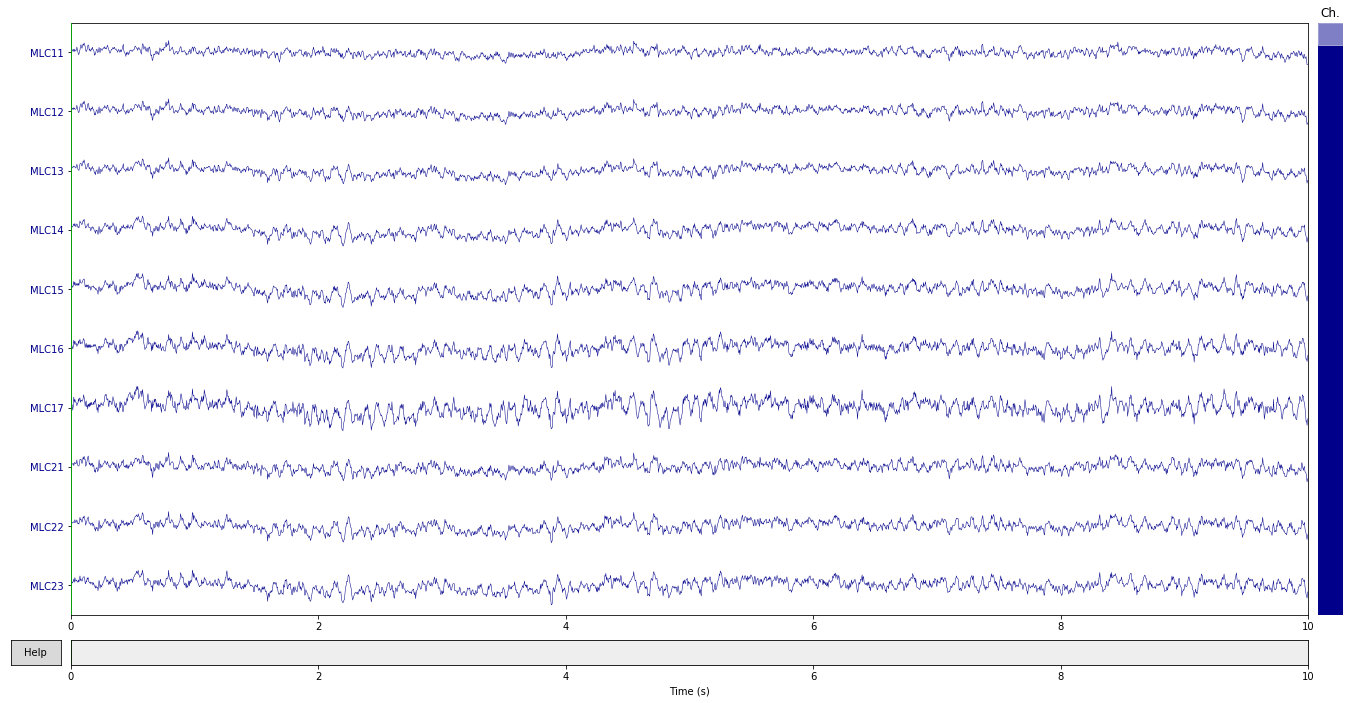

In [13]:
tit = "2nd order grad comp --> tSSS +mvmntComp +destMean -ref"

raw_sss = raw.copy().apply_gradient_compensation(2)
raw_sss = mymaxwell(raw_sss, destination, head_pos)
fig = myrawplot(raw_sss, tit)

Maxwell filtering raw data
    Appending head position result channels and copying original raw data
Removing 5 compensators from info because not all compensation channels were picked.
    Bad MEG channels being reconstructed: ['MLP53', 'MRC12', 'MRC25']
    Processing 0 gradiometers and 269 magnetometers
    Automatic origin fit: head of radius 86.7 mm
    Using origin 1.0, -23.9, 38.5 mm in the head frame
    Processing data using tSSS with st_duration=10.0
        Using 85/95 harmonic components for    0.000  (70/80 in, 15/15 out)
    Processing 1 data chunk


<ipython-input-10-eed8a0bf3da7>:10: RuntimeWarning: Only 4 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  skip_by_annotation=('bad', 'edge', 'bad_acq_skip'))
<ipython-input-10-eed8a0bf3da7>:10: RuntimeWarning: (X, Y) fit (1.0, -23.9) more than 20 mm from head frame origin
  skip_by_annotation=('bad', 'edge', 'bad_acq_skip'))


        Using 86/95 harmonic components for    0.000  (71/80 in, 15/15 out)
        Projecting  0 intersecting tSSS components for    0.000 -   10.000 sec (#1/1) (across 18 positions)
        Using 85/95 harmonic components for    0.000  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    0.516  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    0.916  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    1.316  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    1.916  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    2.116  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    2.716  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    3.616  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    3.716  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    4.216  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    5.816  (7

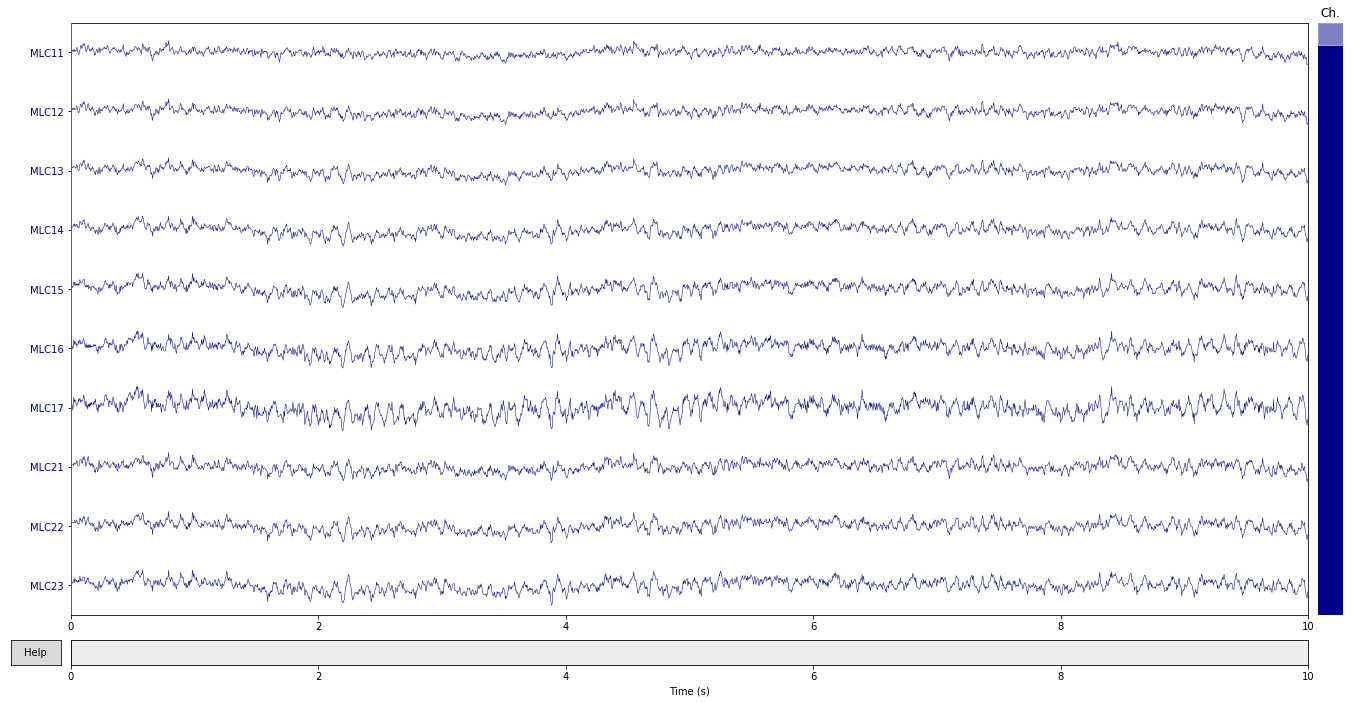

In [14]:
tit = "3rd order grad comp --> tSSS +mvmntComp +destMean -ref"

raw_sss = mymaxwell(raw, destination, head_pos)
fig = myrawplot(raw_sss, tit)

#### Summary
* tSSS alone performs similarly to gradient compensationm, but seems to suppress more higher frequency noise (at least for most channels, see below ...)
* Additional gradient compensation before tSSS removes slow drifts (0th order vs. >1)
* No difference between 1st order and 2nd order gradient comp (but there is definitely a difference without SSS, see above.)
* Subtle difference between 1st order and 3rd order gradient comp (3rd order a little less slow drifts).

### C) Plot raw with tSSS (also on ref_meg) --> grad-comp

Compensator constructed to change 3 -> 0
Applying compensator to loaded data
Maxwell filtering raw data
    Appending head position result channels and copying original raw data
    Bad MEG channels being reconstructed: ['MLP53', 'MRC12', 'MRC25']
    Processing 0 gradiometers and 297 magnetometers (of which 288 are actually KIT gradiometers)
    Automatic origin fit: head of radius 86.7 mm
    Using origin 1.0, -23.9, 38.5 mm in the head frame
    Processing data using tSSS with st_duration=10.0


<ipython-input-15-e4296a0c821c>:12: RuntimeWarning: Only 4 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  skip_by_annotation=('bad', 'edge', 'bad_acq_skip'))
<ipython-input-15-e4296a0c821c>:12: RuntimeWarning: (X, Y) fit (1.0, -23.9) more than 20 mm from head frame origin
  skip_by_annotation=('bad', 'edge', 'bad_acq_skip'))


        Using 84/95 harmonic components for    0.000  (69/80 in, 15/15 out)
    Processing 1 data chunk
        Using 85/95 harmonic components for    0.000  (70/80 in, 15/15 out)
        Projecting  1 intersecting tSSS component  for    0.000 -   10.000 sec (#1/1) (across 18 positions)
        Using 85/95 harmonic components for    0.000  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    0.516  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    0.916  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    1.316  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    1.916  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    2.116  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    2.716  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    3.616  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    3.716  (70/80 in, 15/15 out)
        Using 85/95 harmonic

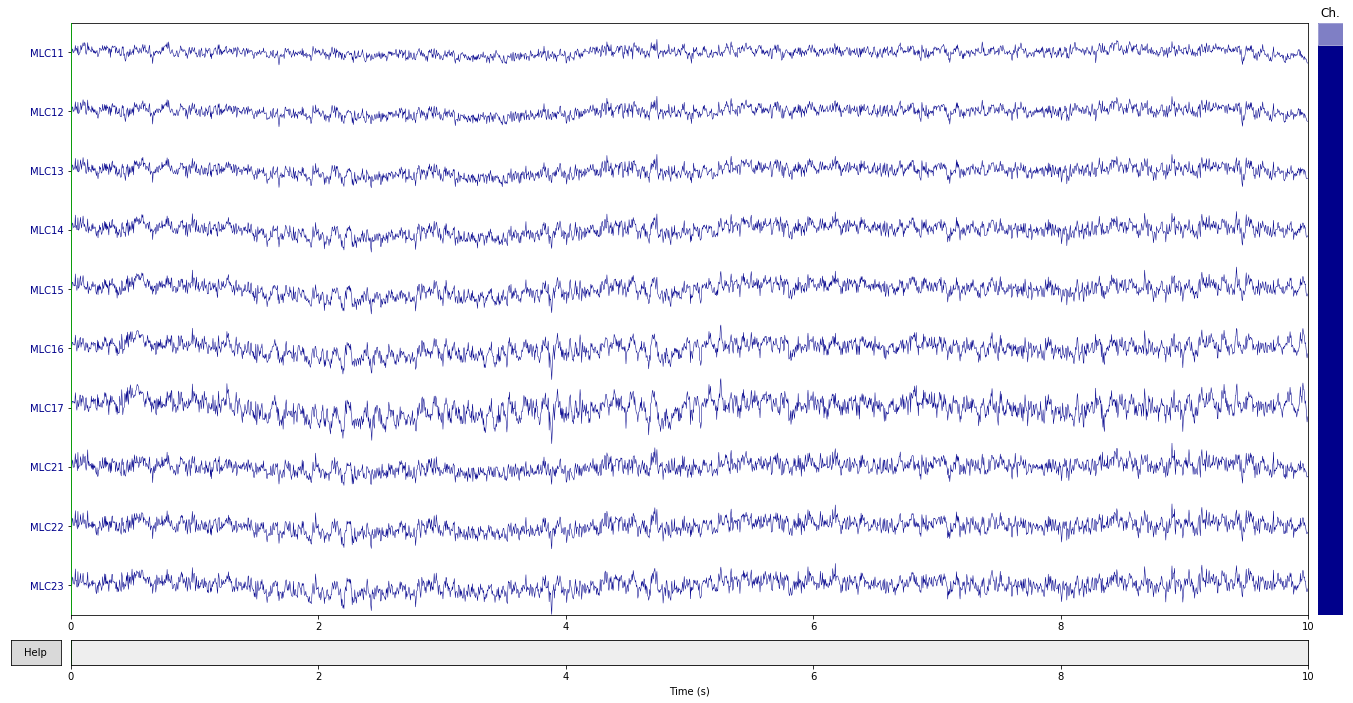

In [15]:
tit = "no grad comp --> tSSS +mvmntComp +destMean +ref"

raw_sss = raw.copy().apply_gradient_compensation(0)
raw_sss = maxwell_filter(raw_sss, st_duration=10,
                           destination= destination,  # in head coordinates
                           st_correlation=.98,  # default
                           ignore_ref=False,  # !! include them (otherwise completely noisy)
                           coord_frame='head',  # default
                           head_pos=head_pos,  # head_pos or None
                           st_fixed=True,
                           st_only=False,
                           skip_by_annotation=('bad', 'edge', 'bad_acq_skip'))

fig = myrawplot(raw_sss, tit)

Compensator constructed to change 0 -> 3
Applying compensator to loaded data


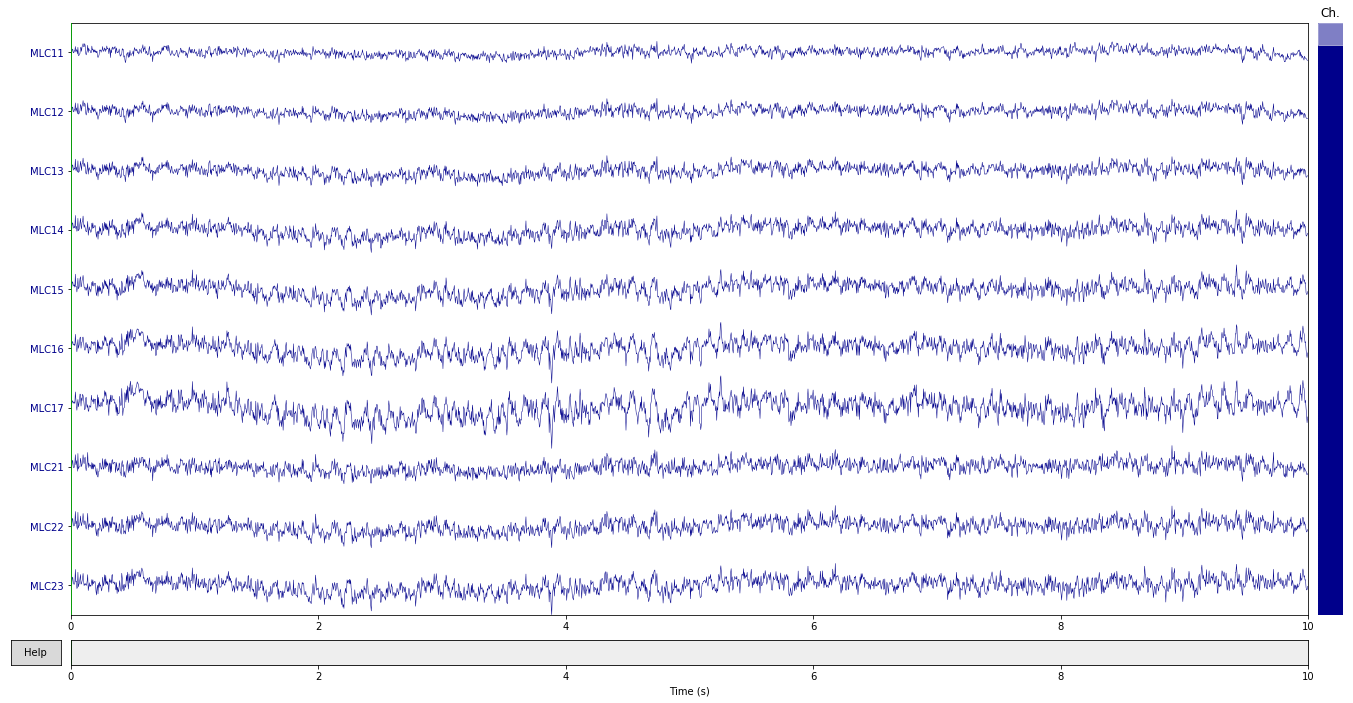

In [16]:
tit = "no grad comp --> tSSS +mvmntComp +destMean +ref --> 3rd order grad comp"

# re-apply ctf grad comp:
raw_sss.apply_gradient_compensation(3)
fig = myrawplot(raw_sss, tit)

#### Summary
tSSS --> gradient compensation is, as expected, not usable.  
However, also only tSSS on the whole array (as suggested by staulu), including ref_meg introduces a lot of noise to the data channels.

### D) Plot some spectra

Compensator constructed to change 3 -> 0
Applying compensator to loaded data
Effective window size : 1.707 (s)


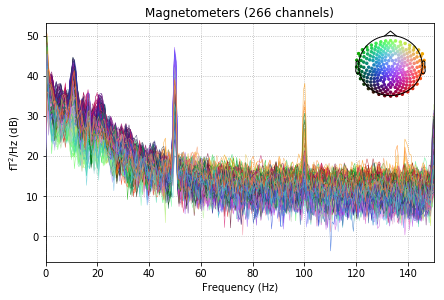

In [17]:
tit = "no grad comp"

picks = mne.pick_types(raw.info, meg=True, ref_meg=False)
raw_tmp = raw.copy().apply_gradient_compensation(0)
fig = raw_tmp.plot_psd(fmax=150, picks=picks)

Effective window size : 1.707 (s)


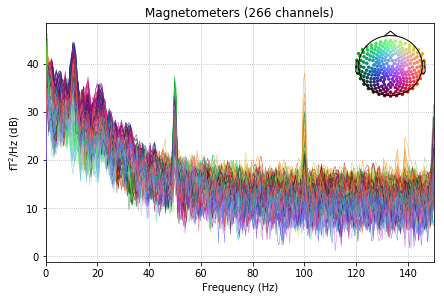

In [18]:
tit = "3rd order grad comp"

fig = raw.plot_psd(fmax=150, picks=picks)

Compensator constructed to change 3 -> 0
Applying compensator to loaded data
Maxwell filtering raw data
    Appending head position result channels and copying original raw data
Removing 5 compensators from info because not all compensation channels were picked.
    Bad MEG channels being reconstructed: ['MLP53', 'MRC12', 'MRC25']
    Processing 0 gradiometers and 269 magnetometers (of which 269 are actually KIT gradiometers)
    Automatic origin fit: head of radius 86.7 mm
    Using origin 1.0, -23.9, 38.5 mm in the head frame
    Processing data using tSSS with st_duration=10.0
        Using 82/95 harmonic components for    0.000  (70/80 in, 12/15 out)
    Processing 1 data chunk


<ipython-input-10-eed8a0bf3da7>:10: RuntimeWarning: Only 4 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  skip_by_annotation=('bad', 'edge', 'bad_acq_skip'))
<ipython-input-10-eed8a0bf3da7>:10: RuntimeWarning: (X, Y) fit (1.0, -23.9) more than 20 mm from head frame origin
  skip_by_annotation=('bad', 'edge', 'bad_acq_skip'))


        Using 83/95 harmonic components for    0.000  (71/80 in, 12/15 out)
        Projecting  1 intersecting tSSS component  for    0.000 -   10.000 sec (#1/1) (across 18 positions)
        Using 82/95 harmonic components for    0.000  (70/80 in, 12/15 out)
        Using 82/95 harmonic components for    0.516  (70/80 in, 12/15 out)
        Using 82/95 harmonic components for    0.916  (70/80 in, 12/15 out)
        Using 82/95 harmonic components for    1.316  (70/80 in, 12/15 out)
        Using 82/95 harmonic components for    1.916  (70/80 in, 12/15 out)
        Using 82/95 harmonic components for    2.116  (70/80 in, 12/15 out)
        Using 82/95 harmonic components for    2.716  (70/80 in, 12/15 out)
        Using 82/95 harmonic components for    3.616  (70/80 in, 12/15 out)
        Using 82/95 harmonic components for    3.716  (70/80 in, 12/15 out)
        Using 82/95 harmonic components for    4.216  (70/80 in, 12/15 out)
        Using 82/95 harmonic components for    5.816  (7

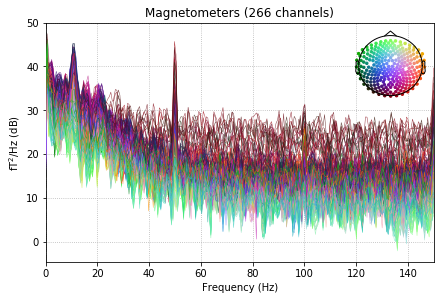

In [19]:
# Maxwell only
tit = "no grad comp --> tSSS +mvmntComp +destMean -ref"

raw_sss = raw.copy().apply_gradient_compensation(0)
raw_sss = mymaxwell(raw_sss, destination, head_pos)
fig = raw_sss.plot_psd(fmax=150, picks=picks)

Maxwell filtering raw data
    Appending head position result channels and copying original raw data
Removing 5 compensators from info because not all compensation channels were picked.
    Bad MEG channels being reconstructed: ['MLP53', 'MRC12', 'MRC25']
    Processing 0 gradiometers and 269 magnetometers
    Automatic origin fit: head of radius 86.7 mm
    Using origin 1.0, -23.9, 38.5 mm in the head frame
    Processing data using tSSS with st_duration=10.0
        Using 85/95 harmonic components for    0.000  (70/80 in, 15/15 out)
    Processing 1 data chunk


<ipython-input-10-eed8a0bf3da7>:10: RuntimeWarning: Only 4 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  skip_by_annotation=('bad', 'edge', 'bad_acq_skip'))
<ipython-input-10-eed8a0bf3da7>:10: RuntimeWarning: (X, Y) fit (1.0, -23.9) more than 20 mm from head frame origin
  skip_by_annotation=('bad', 'edge', 'bad_acq_skip'))


        Using 86/95 harmonic components for    0.000  (71/80 in, 15/15 out)
        Projecting  0 intersecting tSSS components for    0.000 -   10.000 sec (#1/1) (across 18 positions)
        Using 85/95 harmonic components for    0.000  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    0.516  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    0.916  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    1.316  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    1.916  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    2.116  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    2.716  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    3.616  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    3.716  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    4.216  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    5.816  (7

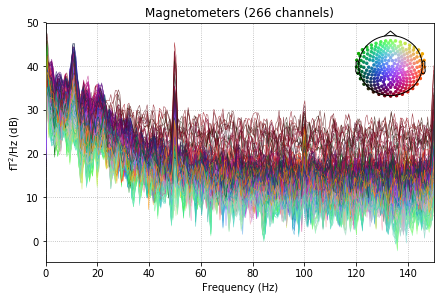

In [20]:
# 3rd order grad compo + Maxwell
tit = "3rd order grad comp --> tSSS +mvmntComp +destMean -ref"

raw_sss = mymaxwell(raw, destination, head_pos)
fig = raw_sss.plot_psd(fmax=150, picks=picks)

Maxwell filtering raw data
    Appending head position result channels and copying original raw data
Removing 5 compensators from info because not all compensation channels were picked.
    Bad MEG channels being reconstructed: ['MLP53', 'MRC12', 'MRC25']
    Processing 0 gradiometers and 269 magnetometers
    Automatic origin fit: head of radius 86.7 mm
    Using origin 1.0, -23.9, 38.5 mm in the head frame
    Processing data using tSSS with st_duration=10.0
        Using 85/95 harmonic components for    0.000  (70/80 in, 15/15 out)
    Processing 1 data chunk


<ipython-input-21-0b1efe4ba0cc>:11: RuntimeWarning: Only 4 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  skip_by_annotation=('bad', 'edge', 'bad_acq_skip'))
<ipython-input-21-0b1efe4ba0cc>:11: RuntimeWarning: (X, Y) fit (1.0, -23.9) more than 20 mm from head frame origin
  skip_by_annotation=('bad', 'edge', 'bad_acq_skip'))


        Using 86/95 harmonic components for    0.000  (71/80 in, 15/15 out)
        Projecting  0 intersecting tSSS components for    0.000 -   10.000 sec (#1/1) (across 18 positions)
        Using 85/95 harmonic components for    0.000  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    0.516  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    0.916  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    1.316  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    1.916  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    2.116  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    2.716  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    3.616  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    3.716  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    4.216  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    5.816  (7

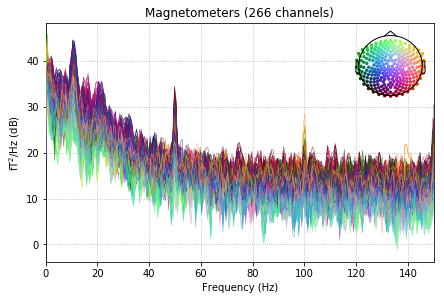

In [21]:
tit = "3rd order grad comp --> tSSS +mvmntComp -destMean -ref"

raw_sss = maxwell_filter(raw, st_duration=10,
                           destination= None,  # in head coordinates
                           st_correlation=.98,
                           ignore_ref=True,
                           coord_frame='head',
                           head_pos=head_pos,  # head_pos or None
                           st_fixed=True,
                           st_only=False,
                           skip_by_annotation=('bad', 'edge', 'bad_acq_skip'))
fig = raw_sss.plot_psd(fmax=150, picks=picks)

#### Summary
Applying any `destination` other than `None` (even using `raw.info['dev_head_t']['trans'][:3, 3]`) during Maxwell filtering makes some - mainly occipital - sensors extremely noisy > 25 Hz (broad band). `head_pos` alone, with `destination=None` does not have this effect.

--> WHAT IS GOING ON HERE?

### Try OTP

Processing MEG data using oversampled temporal projection
    Processing 1 data chunk of (at least) 10.0 sec with hann windowing
    The final 0.001 sec will be lumped into the final window
    Denoising     0.00 -    10.00 sec
Maxwell filtering raw data
    Appending head position result channels and copying original raw data
Removing 5 compensators from info because not all compensation channels were picked.
    Bad MEG channels being reconstructed: ['MLP53', 'MRC12', 'MRC25']
    Processing 0 gradiometers and 269 magnetometers
    Automatic origin fit: head of radius 86.7 mm
    Using origin 1.0, -23.9, 38.5 mm in the head frame
    Processing data using tSSS with st_duration=10.0
        Using 85/95 harmonic components for    0.000  (70/80 in, 15/15 out)
    Processing 1 data chunk


<ipython-input-22-c293e85f09ca>:11: RuntimeWarning: Only 4 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  skip_by_annotation=('bad', 'edge', 'bad_acq_skip'))
<ipython-input-22-c293e85f09ca>:11: RuntimeWarning: (X, Y) fit (1.0, -23.9) more than 20 mm from head frame origin
  skip_by_annotation=('bad', 'edge', 'bad_acq_skip'))


        Using 86/95 harmonic components for    0.000  (71/80 in, 15/15 out)
        Projecting 10 intersecting tSSS components for    0.000 -   10.000 sec (#1/1) (across 18 positions)
        Using 85/95 harmonic components for    0.000  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    0.516  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    0.916  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    1.316  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    1.916  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    2.116  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    2.716  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    3.616  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    3.716  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    4.216  (70/80 in, 15/15 out)
        Using 85/95 harmonic components for    5.816  (7

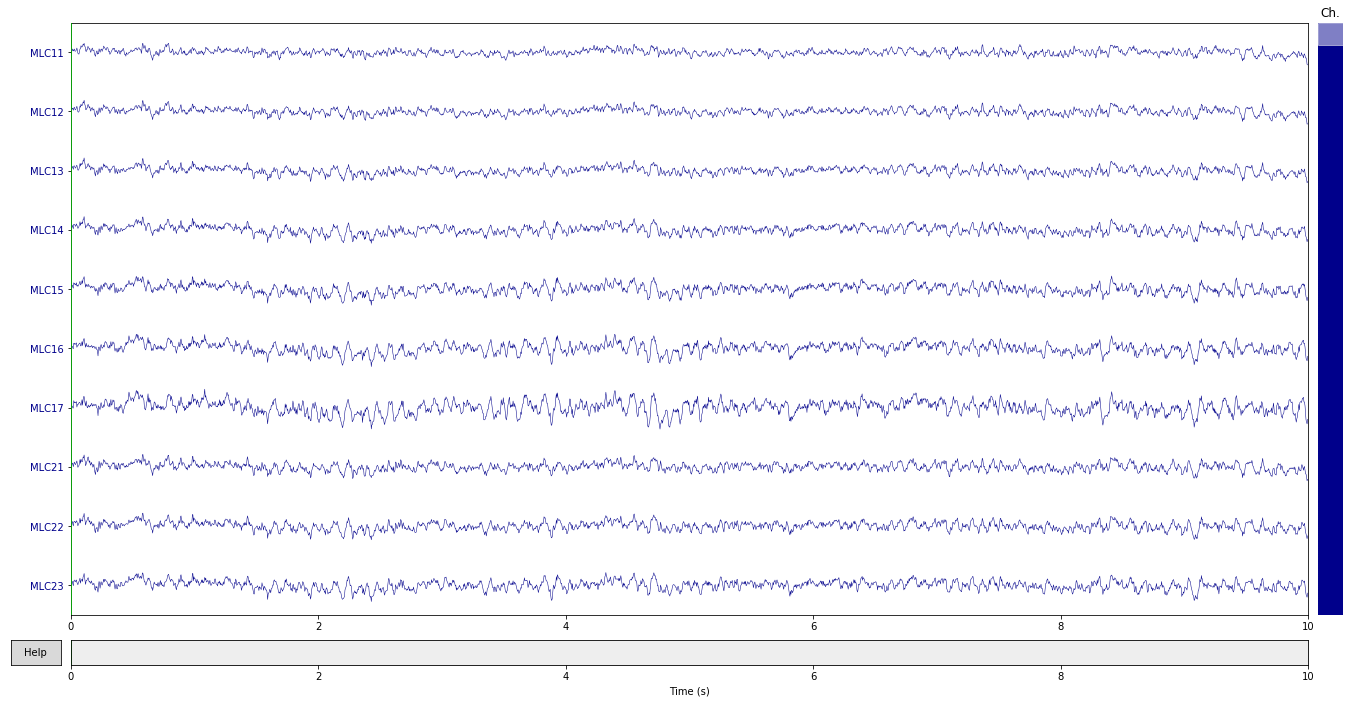

Effective window size : 1.707 (s)


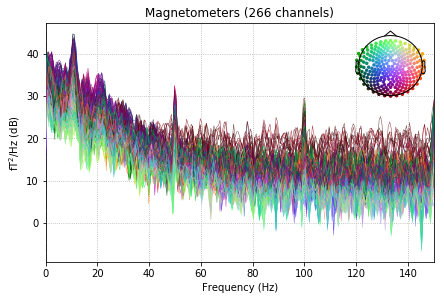

In [22]:
tit = '3rd order grad comp --> OTP --> tSSS +mvmntComp +dest -ref'
raw_clean = mne.preprocessing.oversampled_temporal_projection(raw)
raw_sss = maxwell_filter(raw_clean, st_duration=10,
                           destination= destination,  # in head coordinates
                           st_correlation=.98,
                           ignore_ref=True,
                           coord_frame='head',
                           head_pos=head_pos,  # head_pos or None
                           st_fixed=True,
                           st_only=False,
                           skip_by_annotation=('bad', 'edge', 'bad_acq_skip'))
# OTP again:
# raw_sss = mne.preprocessing.oversampled_temporal_projection(raw_sss)
myrawplot(raw_sss, tit)
fig = raw_sss.plot_psd(fmax=150, picks=picks)

#### Summary
OTP before Maxwell filtering alleviates the broad-band-noise problem a lot, and completely until 45 Hz. Cool! :)  
(A second run of OTP after maxwell_filter does give any obious improvement.)

Question: How should we adapt st_correlation to OTP? What is the criterion to select this parameter?